<a href="https://colab.research.google.com/github/ruthtsai/Deep-Generative-Models/blob/main/HW1_VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1, Avg loss: 163.2017
Epoch 2, Avg loss: 121.2507
Epoch 3, Avg loss: 114.3694
Epoch 4, Avg loss: 111.5121
Epoch 5, Avg loss: 109.7923
Epoch 6, Avg loss: 108.5827
Epoch 7, Avg loss: 107.8067
Epoch 8, Avg loss: 107.1402
Epoch 9, Avg loss: 106.6274
Epoch 10, Avg loss: 106.2357


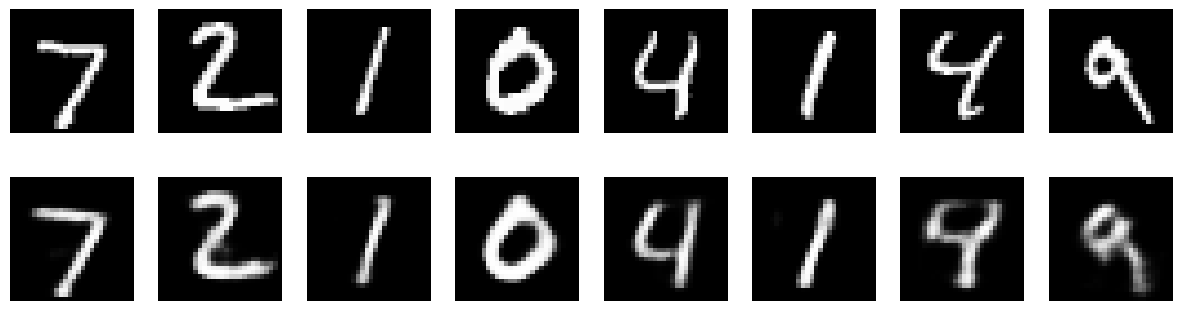

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ========== 1. 參數設定 ==========
batch_size = 128
latent_dim = 20  # 潛在空間維度
epochs = 10
lr = 1e-3  # 學習率

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== 2. 載入 MNIST 資料集 ==========
transform = transforms.ToTensor()


train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ========== 3. 定義 VAE 模型 ==========
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # 編碼器：784 -> 400 -> (mu, logvar)
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # 解碼器：latent -> 400 -> 784
        self.fc2 = nn.Linear(latent_dim, 400)
        self.fc3 = nn.Linear(400, 28*28)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # reparameterization trick
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# ========== 4. 定義損失函數 ==========
def loss_function(recon_x, x, mu, logvar):
    # 重建誤差 (binary cross entropy)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence: 測量 q(z|x) 與 N(0,1) 的差距
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

# ========== 5. 訓練模型 ==========
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()
for epoch in range(1, epochs+1):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28*28).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch}, Avg loss: {train_loss / len(train_loader.dataset):.4f}")

# ========== 6. 測試與重建結果 ==========
model.eval()
with torch.no_grad():
    test_batch, _ = next(iter(test_loader))
    test_batch = test_batch.view(-1, 28*28).to(device)
    recon_batch, _, _ = model(test_batch)

# 顯示原始與重建圖片
n = 8
plt.figure(figsize=(15, 4))
for i in range(n):
    # 原始圖片
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_batch[i].cpu().view(28, 28), cmap='gray')
    plt.axis("off")

    # 重建圖片
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(recon_batch[i].cpu().view(28, 28), cmap='gray')
    plt.axis("off")
plt.show()
